# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random
import math

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [7]:
def add_column_to(X:np.ndarray):
    ones = np.ones((X.shape[0],1))
    return np.hstack((ones, X))

In [2]:
def _tr(arr, old_x1, old_x2, new_x1, new_x2):
    for idx in range(arr.size):
        if arr[idx] == old_x1:
            arr[idx]  = new_x1
        else:
            arr[idx]  = new_x2

In [4]:
class Perceptron:
    def __init__(self, iterations=100):
        self.iterations = iterations
        self.w = None
    
    def _predict_impl(self, X, w):
        return np.sign(np.dot(X, w))


    def _fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for iter in range(self.iterations):
            res = self._predict_impl(X, self.w)
            idx_update_s = np.where(res != y)[0]
            for idx in idx_update_s:
                self.w = self.w + y[idx] * X[idx]


    def fit(self, X, y):
        y_ = y.copy()
        self.labels = np.unique(y_)
        assert self.labels.size == 2
        _tr(y_, self.labels[0], self.labels[1], (-1), 1)

        X_ = add_column_to(X)
        self._fit(X_, y_)

    def predict(self, X):
        X_ = add_column_to(X)
        raw_predict = self._predict_impl(X_, self.w)
        _tr(raw_predict, (-1), 1, self.labels[0], self.labels[1])

        return raw_predict

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [5]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

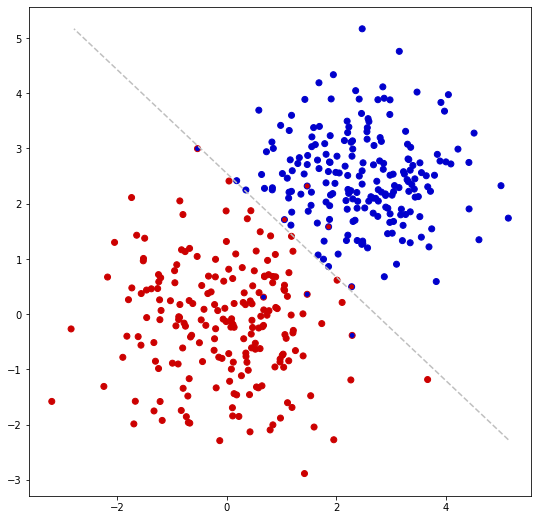

In [8]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

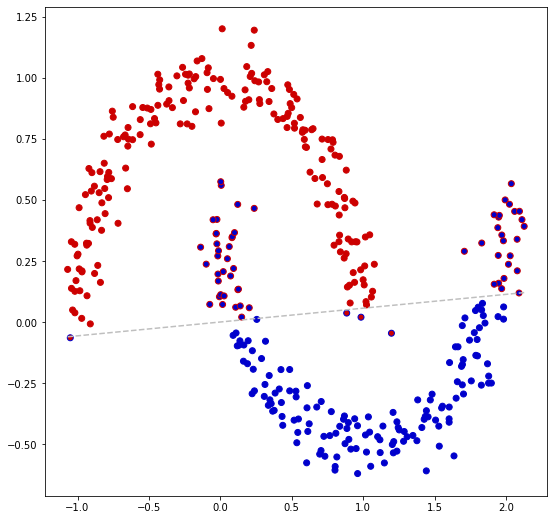

In [9]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [10]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.iterations = iterations
        self.w = None

    def _predict_impl(self, X, w):
        return np.sign(np.dot(X, w))


    def _fit(self, X, y):
        w = np.ones(X.shape[1])
        w_best = np.ones(X.shape[1])
        best_error = 100000000

        for iter in range(self.iterations):
            res = self._predict_impl(X, w)
            idx_update_s = np.where(res != y)[0]
            # update best
            current_error = idx_update_s.shape[0]
            if current_error < best_error:
                best_error, w_best = current_error, w
          #
            for idx in idx_update_s:
                w = w + y[idx] * X[idx] 
        #
        res = self._predict_impl(X, w)
        idx_update_s = np.where(res != y)[0]
        # update best
        current_error = idx_update_s.shape[0]
        if current_error < best_error:
            best_error, w_best = current_error, w
        #
        self.w = w_best
        
    def fit(self, X, y):
        y_ = y.copy()
        self.labels = np.unique(y_)
        assert self.labels.size == 2
        _tr(y_, self.labels[0], self.labels[1], (-1), 1)

        X_ = add_column_to(X)
        self._fit(X_, y_)


    def predict(self, X):
        X_ = add_column_to(X)
        raw_predict = self._predict_impl(X_, self.w)
        _tr(raw_predict, (-1), 1, self.labels[0], self.labels[1])
        return raw_predict

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

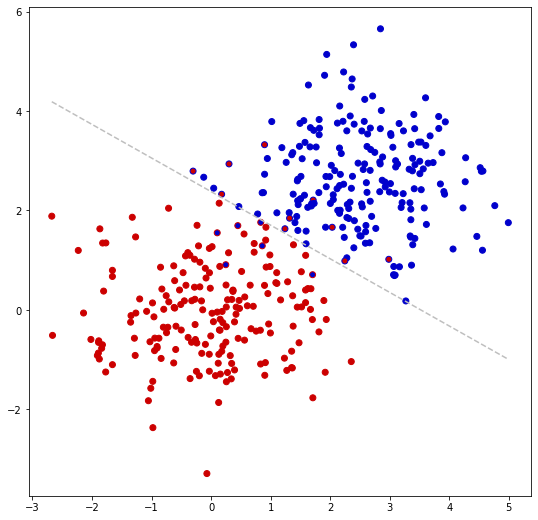

In [11]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

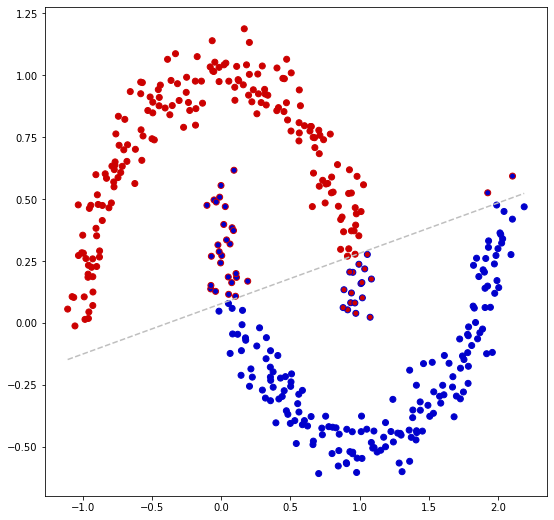

In [12]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [57]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean((y_true - y_predicted) * (y_true - y_predicted))

def transform_images(images):
    """
    Переводит каждое изображение в вектор из двух элементов.
        
    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    res = np.zeros((images.shape[0], 2))
    for idx, image in enumerate(images):
        intensity = (np.sum(image * image) / image.size) * (image[image > 0].size / image.size)
        symmetry = mse(np.flip(image.T, axis=1).reshape(image.size), image.T.reshape(image.size))
        res[idx] = np.array([intensity, symmetry])
  
    symm = res.T[1].copy()
    alptha = 0.2
    res.T[1] = alptha * math.e ** (-(symm - np.mean(symm)) / (2 * np.std(symm)))

    return res

def get_digits(train_image_ids, test_image_ids):
    data = datasets.load_digits()
    images_train, labels_train = data.images[train_image_ids['ImageId'].values], data.target[train_image_ids['ImageId'].values]
    images_test, labels_test = data.images[test_image_ids['ImageId'].values], data.target[test_image_ids['ImageId'].values]
    return images_train, labels_train, images_test, labels_test

def get_digits_by_mask(images, labels, y0, y1):
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    return images, labels

def get_x_y(train_image_ids, test_image_ids, y0=1, y1=5):
    X_train, y_train, X_test, y_test = get_digits(train_image_ids, test_image_ids)
    X_train, y_train = get_digits_by_mask(X_train, y_train, y0, y1)
    X_train = transform_images(X_train)
    X_test, y_test = get_digits_by_mask(X_test, y_test, y0, y1)
    X_test = transform_images(X_test)

    return X_train, y_train, X_test, y_test

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [41]:
train_ids, test_ids = pd.read_csv("x_digits_train.csv"), pd.read_csv("x_digits_test.csv")
X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids)

In [20]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

Accuracy: 0.7945205479452054


In [21]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

Accuracy: 0.8767123287671232


In [22]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = np.arange(X_test.shape[0])
submission["Expected"] = c.predict(X_test)
submission.to_csv('submission.csv', index=False)

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [59]:
def norm_get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

In [60]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = norm_get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=200)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6757128599433571


In [61]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = norm_get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=200)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6966694297358649
